In [1]:
#imports

import tensorflow as tf
import cv2 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import random as rand
import os
import matplotlib.pyplot as plt
import time

# image dimensions (based on dataset image sizes)
img_height = 224
img_width = 224

# use CSRT Tracker for object tracking
# allows selection of image to send to model for processing
tracker = cv2.TrackerCSRT_create()

In [2]:
# detect face function
def detect_face(img):
    detections = img.copy()
    faceDetector = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")
    faces = faceDetector.detectMultiScale(detections, scaleFactor=1.1, minNeighbors=5, minSize=(10,10), maxSize=(300,300))
    
    # rectangles = []
    # for(x,y,w,h) in faces:
    #     cv2.rectangle(detections, (x,y), (x+w, y+h), (0, 255, 255), 4)
    #     rectangles.append((x,y,w,h))
    return detections, faces

In [3]:
# create dict of shape categories and indicies that line up with indicies used in model training 

shapes_list = os.listdir("Datasets/hand-drawn-shapes/train")

# DS_Store is hidden file that sometimes is added to list, needs to be removed if present
shapes_list.remove('.DS_Store')

# indicies in model follow order of folders in directory, which is alphabetical
shapes_set = {index:shape for (index, shape) in enumerate(sorted(shapes_list))}

print(shapes_set)

{0: 'circle', 1: 'square', 2: 'triangle'}


In [4]:
# load model

model = keras.models.load_model('./multiclass_shapes.keras')


In [5]:
# Function to classify a new image
def classify_image(model, image_path):
    # get image from path
    img = load_img(image_path, target_size=(img_height, img_width))
    
    img_array = img_to_array(img) / 255.0 #Normalize the image
    
    # apply threshold to image for easier image recognition
    threshold = 0.5
    img_array[img_array < threshold] = 0 #all img elements less than threshold equal to 0, rest equal to 1
    img_array[img_array >= threshold] = 1
    
    # img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    # plt.imshow(img_array)
    
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    prediction = model.predict(img_array)
    # get the predicted cateogry from the prediction array 
    prediction = np.argmax(prediction)
    
    return prediction


In [6]:

# call clasify image with image path and display selected image (for error analysis purposes
# )
def predict():
    img_path = "new_img.jpg"

    prediction = classify_image(model, img_path)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    return prediction

In [7]:
# choose random shape from dict
def generate_shape_prompt():
    # print(rand.choice(shapes_set))
    return rand.choice(shapes_set)

In [8]:
face_image = cv2.imread("images/neutral.png")

2025-02-25 20:34:36.774 python[16672:8250939] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


-1

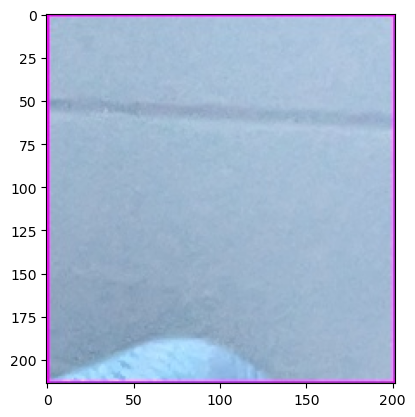

In [9]:
capture = cv2.VideoCapture(1)
ret, frame = capture.read()

# flags

shape_track = False
face_replace = False

# initial values for score counter, shape to draw, and results text
prompt_shape = generate_shape_prompt()
results_text = ""
score_counter = 0


# main loop
while True:
    ok, frame = capture.read()
    
    if not ok:
        break
    
    key = cv2.waitKey(10) & 0xFF
    
    # key bindings
    
    # begin shape highligting/classification process
    if key == ord('b'):
        shape_track = True
    # toggle replacing face with emoticon
    if key == ord('f'):
        face_replace = not face_replace
    # score overrides (for demo purposes)
    if key == ord('s'):
        score_counter += 1
    if key == ord('m'):
        score_counter -= 1
    
        
    # display text for score and shape prompt
    cv2.rectangle(frame, (int(frame.shape[1]/2)-135, 10), (int(frame.shape[1]/2)+180, 55), (255, 255, 255), -1)
    cv2.putText(frame, f"Draw a {prompt_shape}", (int(frame.shape[1]/2)-100, 40), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,0), 2)  
    cv2.putText(frame, f"Score: {score_counter}", (30, 40), cv2.FONT_HERSHEY_DUPLEX, 1, (179, 132, 5), 5)                            
                              
    
    if shape_track:
            # allow user to highlight drawn shape to be classified
            bbox = cv2.selectROI("Highlight the Shape", frame)
            ok = tracker.init(frame, bbox)
            
            # Destroy the ROI selection window after ROI is selected
            cv2.destroyWindow("Highlight the Shape")
            
            # get dimensions of bbox
            (x,y,w,h) = [int(v) for v in bbox]
            cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,255), 2)
            
            # use bbox dimensions/coords to save bbox as jpg image
            img_save = frame[y:y+h, x:x+w]
            cv2.imwrite("new_img.jpg", img_save)
            
            # predict shape and display results
            predicted_shape = predict()

            # update score and results text
            if shapes_set[predict()] == prompt_shape:
                score_counter += 1
                results_text = f"Correct, this is a {shapes_set[predict()]}!"
                
            else:
                score_counter -=1
                results_text = f"Sorry, this is a {shapes_set[predict()]}."
                
            
            # turn off detecting shape mode
            shape_track = False
            # create new prompt
            prompt_shape = generate_shape_prompt()
            
    # display different face on user depending on score
    if face_replace:
        if score_counter < 0:
            face_image = cv2.imread("images/frown.png")
        elif score_counter == 0:
            face_image = cv2.imread("images/neutral.png")
        else:
            face_image = cv2.imread("images/smiley.png")
        frame, rect_values = detect_face(frame)
        # time.sleep(1/30) #30 fps
        
        # find detected face(s)
        for item in rect_values:
            x,y,w,h = item
            # resize image
            cur_face_image = cv2.resize(face_image, (rect_values[0][2], rect_values[0][3]))

            # replace detected face section of frame with emoticon image
            try:
                frame[y:y+h, x:x+w] = cur_face_image
            except ValueError: #don't add image to area if error occurs (dimensions don't match, etc)
                break
            
    # add results text to frame
    if results_text != "":
        cv2.rectangle(frame, (int(frame.shape[1]/2)-185, 670), (int(frame.shape[1]/2)+290, 715), (255, 255, 255), -1)
    cv2.putText(frame, results_text, (int(frame.shape[1]/2)-150, 700), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 2)                            
    # ok, bbox = tracker.update(frame)
        
    cv2.imshow("Video", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

